In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

## Dataset information as per Kaggle (https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data)

1. **train.csv** - The training set.
   * `Id` Unique identifier for each observation.
   * `AB-GL` Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
   * `Class` A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
2. **test.csv** - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
3. **greeks.csv** - Supplemental metadata, only available for the training set.
   * `Alpha` Identifies the type of age-related condition, if present.
     * `A` No age-related condition. Corresponds to class 0.
     * `B`, `D`, `G` The three age-related conditions. Correspond to class 1.
   * `Beta`, `Gamma`, `Delta` Three experimental characteristics.
   * `Epsilon` The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.

In [4]:
greeks = pd.read_csv('../data/greeks.csv')
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

print('Shape of greeks df:', greeks.shape)
print('Shape of test df:', test.shape)
print('Shape of train df:', train.shape)

df = pd.merge(train, greeks, on='id')

Shape of greeks df: (617, 6)
Shape of test df: (5, 57)
Shape of train df: (617, 58)


In [5]:
df.isna().sum()

id         0
ab         0
af         0
ah         0
am         0
          ..
alpha      0
beta       0
gamma      0
delta      0
epsilon    0
Length: 63, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 63 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       617 non-null    object 
 1   ab       617 non-null    float64
 2   af       617 non-null    float64
 3   ah       617 non-null    float64
 4   am       617 non-null    float64
 5   ar       617 non-null    float64
 6   ax       617 non-null    float64
 7   ay       617 non-null    float64
 8   az       617 non-null    float64
 9   bc       617 non-null    float64
 10  bd       617 non-null    float64
 11  bn       617 non-null    float64
 12  bp       617 non-null    float64
 13  bq       557 non-null    float64
 14  br       617 non-null    float64
 15  bz       617 non-null    float64
 16  cb       615 non-null    float64
 17  cc       614 non-null    float64
 18  cd       617 non-null    float64
 19  cf       617 non-null    float64
 20  ch       617 non-null    float64
 21  cl       617 non

[Text(0, 0.5, '')]

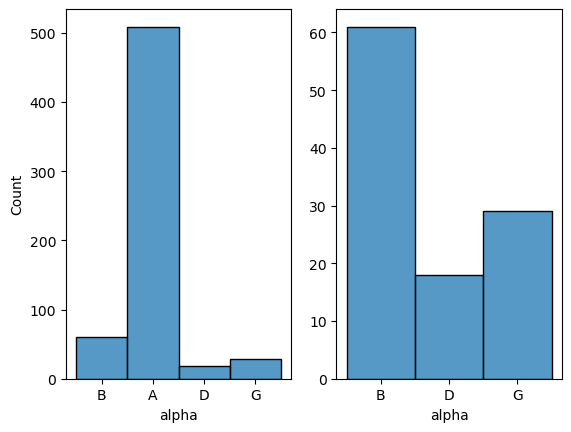

In [7]:
## Looking at distribution of conditions

fig, (ax1, ax2) = plt.subplots(1, 2)

g1 = sns.histplot(
        data=greeks,
        stat='count',
        x='alpha',
        ax=ax1
)

g2 = sns.histplot(
        data=greeks.drop(greeks[greeks.alpha == 'A'].index),
        stat='count',
        x='alpha',
        ax=ax2
)
g2.set(ylabel=None)


In [8]:
condition_counts = greeks.groupby('alpha', as_index=False).count()
a_perc = (condition_counts[condition_counts.alpha == 'A'].id/condition_counts.id.sum())[0]
print(f"When looking at all three conditions and lack of conditions, {round(a_perc*100, 2)}% of the sample do not have conditions")
condition_counts.drop(condition_counts[condition_counts.alpha == 'A'].index, inplace=True)
condition_counts['perc'] = condition_counts.id/condition_counts.id.sum()
for index, row in condition_counts[['alpha','perc']].iterrows():
    print(f'Condition {row["alpha"]} makes up {round(row["perc"] * 100, 2)}% of the condtions')

When looking at all three conditions and lack of conditions, 82.5% of the sample do not have conditions
Condition B makes up 56.48% of the condtions
Condition D makes up 16.67% of the condtions
Condition G makes up 26.85% of the condtions


In [5]:
# Replaces class with respective condition (should we do this? Maybe better to have in a different col)
# train.loc[train.id == greeks.id, 'class'] = greeks.alpha

In [ ]:
# cm = train.corr(numeric_only=False).values
# hm = sns.heatmap(
#     cm,
#     row_names=train.columns,
#     column_names=train.columns,
#     figsize=(6, 6)
# )

In [10]:
min_max = train.agg(['min', 'max']).transpose()
min_max["max"] = pd.to_numeric(min_max['max'], errors='coerce')
min_max["min"] = pd.to_numeric(min_max['min'], errors='coerce')
min_max = min_max.dropna()

min_max = min_max[min_max['max'] <= 120]
min_max = min_max[min_max['max'] >= 40]
min_max = min_max[min_max['min'] >= 3]

In [10]:
train['ej'].replace(to_replace=['A', 'B'], value=[0, 1], inplace=True)
target_variable = train['class']
features_variable=train.drop(['class', 'id'],axis=1)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
features_variable = imputer.fit_transform(features_variable)

standarized_data = StandardScaler().fit_transform(features_variable)

In [37]:
from sklearn.manifold import TSNE
model = TSNE(n_components=30, random_state=0,perplexity=50, n_iter=5000, method='exact')
tsne_data = model.fit_transform(standarized_data)

In [38]:
print(tsne_data.shape)

(617, 30)
